# Functional API

In [1]:
import tensorflow as tf

### Sequential

In [2]:
model=tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28,1)),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(10,activation='softmax')
])

### Functional

In [3]:
input=tf.keras.layers.Input(shape=(28,28,1))
x=tf.keras.layers.Flatten()(input)
x=tf.keras.layers.Dense(64,activation='relu')(x)
output=tf.keras.layers.Dense(10,activation='softmax')(x)

In [4]:
model=tf.keras.models.Model(inputs=input,outputs=output)

#### train & test

In [6]:
mnist = tf.keras.datasets.fashion_mnist
(training_images, training_labels), (test_images, test_labels) = mnist.load_data()
training_images = training_images / 255.0
test_images = test_images / 255.0

4431872/4422102 [==============================] - 1s 0us/step


In [8]:
model.compile(optimizer=tf.keras.optimizers.Adam(),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model.fit(training_images, training_labels, epochs=5)
model.evaluate(test_images, test_labels)

Epoch 1/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5165 - accuracy: 0.8196
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3934 - accuracy: 0.8605
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3589 - accuracy: 0.8716
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3322 - accuracy: 0.8790
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - loss: 0.3744 - accuracy: 0.8692


[0.37444353103637695, 0.8691999912261963]

---

### Multi-output Model

In [38]:
from ucimlrepo import fetch_ucirepo 
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [8]:
energy_efficiency = fetch_ucirepo(id=242)
data=energy_efficiency.data.original

In [27]:
def norm(x,train_stats):
    return (x-train_stats['mean'])/train_stats['std']

In [23]:
train, test = train_test_split(data, test_size=0.2)
train_stats = train.describe()

In [24]:
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = np.array(train.pop('Y1')),np.array(train.pop('Y2'))
test_Y = np.array(test.pop('Y1')),np.array(test.pop('Y2'))

norm_train_X = norm(train,train_stats)
norm_test_X = norm(test,train_stats)

#### model

In [33]:
input_layer=tf.keras.layers.Input(shape=(len(train.columns,)))
first_dense=tf.keras.layers.Dense(128,activation='relu')(input_layer)
second_dense=tf.keras.layers.Dense(128,activation='relu')(first_dense)
third_dense=tf.keras.layers.Dense(64,activation='relu')(second_dense)

output_y1=tf.keras.layers.Dense(1,activation='linear', name='y1_output')(second_dense)
output_y2=tf.keras.layers.Dense(1,activation='linear', name='y2_output')(third_dense)

model=tf.keras.models.Model(inputs=input_layer,outputs=[output_y1,output_y2])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 8)]          0           []                               
                                                                                                  
 dense_15 (Dense)               (None, 128)          1152        ['input_5[0][0]']                
                                                                                                  
 dense_16 (Dense)               (None, 128)          16512       ['dense_15[0][0]']               
                                                                                                  
 dense_17 (Dense)               (None, 64)           8256        ['dense_16[0][0]']               
                                                                                            

In [35]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(optimizer=optimizer,loss={'y1_output': 'mse', 'y2_output': 'mse'},metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),'y2_output': tf.keras.metrics.RootMeanSquaredError()})

#### training

In [1]:
history = model.fit(norm_train_X, train_Y,epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

In [37]:
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

5/5 [==============================] - 0s 0s/step - loss: 0.5798 - y1_output_loss: 0.1280 - y2_output_loss: 0.4518 - y1_output_root_mean_squared_error: 0.3577 - y2_output_root_mean_squared_error: 0.6722
Loss = 0.5797784924507141, Y1_loss = 0.12795747816562653, Y1_mse = 0.35771143436431885, Y2_loss = 0.4518210291862488, Y2_mse = 0.6721763610839844


Text(0.5, 1.0, 'Y2')

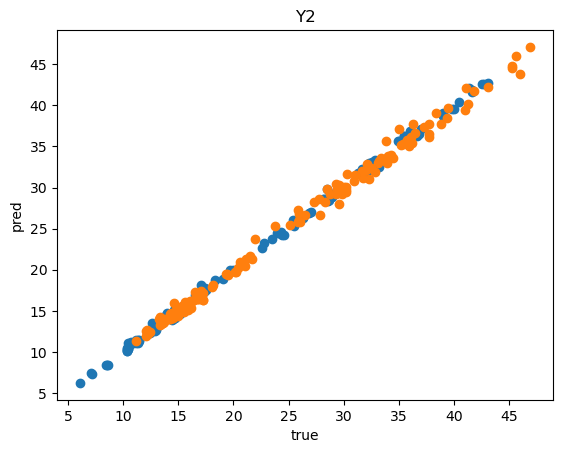

In [49]:
Y_pred = model.predict(norm_test_X)
plt.scatter(test_Y[0], Y_pred[0])
plt.title('Y1')
plt.xlabel('true')
plt.ylabel('pred')
plt.scatter(test_Y[1], Y_pred[1])
plt.title('Y2')

---

### Siamese Network

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K

In [5]:
def create_pairs(x, digit_indices):
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(10)]) - 1
    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)


def create_pairs_on_set(images, labels):
    digit_indices = [np.where(labels == i)[0] for i in range(10)]
    pairs, y = create_pairs(images, digit_indices)
    y = y.astype('float32')
    return pairs, y

In [6]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

train_images = train_images / 255.0
test_images = test_images / 255.0

tr_pairs, tr_y = create_pairs_on_set(train_images, train_labels)
ts_pairs, ts_y = create_pairs_on_set(test_images, test_labels)

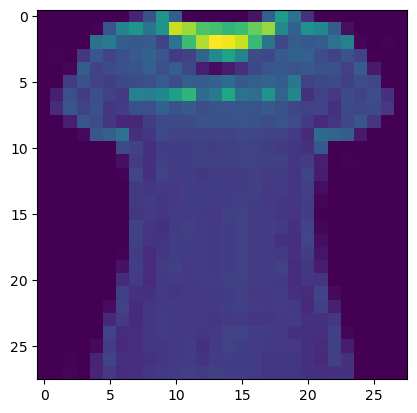

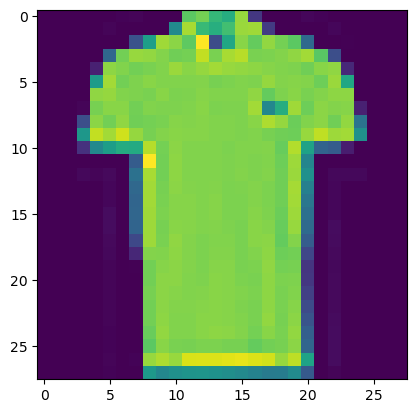

1.0


In [7]:
this_pair = 8
#plt.subplots(1,2)
plt.imshow(ts_pairs[this_pair][0])
plt.show()
plt.imshow(ts_pairs[this_pair][1])
plt.show()

print(ts_y[this_pair])

#### model

In [8]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return (y_true * square_pred + (1 - y_true) * margin_square)
    return contrastive_loss

In [9]:
input=tf.keras.layers.Input(shape=(28,28,),name='input_layer')
x=tf.keras.layers.Flatten()(input)
x=tf.keras.layers.Dense(128,activation='relu')(x)
x=tf.keras.layers.Dropout(0.1)(x)
x=tf.keras.layers.Dense(128,activation='relu')(x)
x=tf.keras.layers.Dropout(0.1)(x)
x=tf.keras.layers.Dense(128,activation='relu')(x)
base_network=tf.keras.models.Model(inputs=input,outputs=x)

In [10]:
input_a=tf.keras.layers.Input(shape=(28,28,),name='left_input')
vect_output_a=base_network(input_a)

input_b=tf.keras.layers.Input(shape=(28,28,),name='right_input')
vect_output_b=base_network(input_b)

output=tf.keras.layers.Lambda(euclidean_distance, name="output_layer", output_shape=eucl_dist_output_shape)([vect_output_a, vect_output_b])

model=tf.keras.models.Model(inputs=[input_a,input_b],outputs=output)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 left_input (InputLayer)        [(None, 28, 28)]     0           []                               
                                                                                                  
 right_input (InputLayer)       [(None, 28, 28)]     0           []                               
                                                                                                  
 model_2 (Functional)           (None, 128)          133504      ['left_input[0][0]',             
                                                                  'right_input[0][0]']            
                                                                                                  
 output_layer (Lambda)          (None, 1)            0           ['model_2[0][0]',          

#### training

In [11]:
model.compile(loss=contrastive_loss_with_margin(margin=1),optimizer=tf.keras.optimizers.RMSprop())
history = model.fit([tr_pairs[:,0], tr_pairs[:,1]], tr_y, epochs=20, batch_size=128, validation_data=([ts_pairs[:,0], ts_pairs[:,1]], ts_y))

Epoch 1/20
938/938 [==============================] - 9s 8ms/step - loss: 0.1114 - val_loss: 0.0843
Epoch 2/20
938/938 [==============================] - 7s 7ms/step - loss: 0.0792 - val_loss: 0.0813
Epoch 3/20
938/938 [==============================] - 6s 7ms/step - loss: 0.0702 - val_loss: 0.0710
Epoch 4/20
938/938 [==============================] - 7s 7ms/step - loss: 0.0654 - val_loss: 0.0721
Epoch 5/20
938/938 [==============================] - 7s 8ms/step - loss: 0.0624 - val_loss: 0.0653
Epoch 6/20
938/938 [==============================] - 7s 7ms/step - loss: 0.0609 - val_loss: 0.0666
Epoch 7/20
938/938 [==============================] - 7s 7ms/step - loss: 0.0591 - val_loss: 0.0657
Epoch 8/20
938/938 [==============================] - 7s 7ms/step - loss: 0.0581 - val_loss: 0.0666
Epoch 9/20
938/938 [==============================] - 6s 7ms/step - loss: 0.0568 - val_loss: 0.0680
Epoch 10/20
938/938 [==============================] - 7s 7ms/step - loss: 0.0559 - val_loss: 0.0663

In [13]:
loss = model.evaluate(x=[ts_pairs[:,0],ts_pairs[:,1]], y=ts_y)

625/625 [==============================] - 1s 2ms/step - loss: 0.0638


In [14]:
def compute_accuracy(y_true, y_pred):
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)

In [15]:
y_pred_train = model.predict([tr_pairs[:,0], tr_pairs[:,1]])
train_accuracy = compute_accuracy(tr_y, y_pred_train)

y_pred_test = model.predict([ts_pairs[:,0], ts_pairs[:,1]])
test_accuracy = compute_accuracy(ts_y, y_pred_test)

print(f'accuracy: train {train_accuracy}, test {test_accuracy}')

accuracy: train 0.9403067177862977, test 0.9129129129129129


#### distance between two wectors is prediction

pred: 0.08457189053297043            pred: 0.8989872932434082
label: 1.0                           label: 0.0


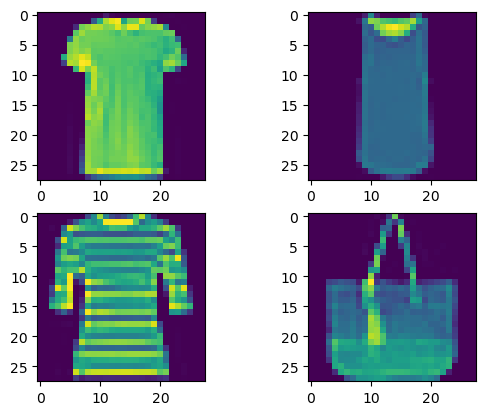

In [59]:

f,axarr=plt.subplots(2,2)
axarr[0,0].imshow(tr_pairs[8,0])
axarr[1,0].imshow(tr_pairs[8,1])
axarr[0,1].imshow(tr_pairs[3,0])
axarr[1,1].imshow(tr_pairs[3,1])
print(f'pred: {y_pred_train[8]}            pred: {y_pred_train[3]}')
print(f'label: {tr_y[8]}                           label: {tr_y[3]}')